### LSTM을 활용한 자연어 문서 분류 예측.

In [1]:
import pandas as pd
import numpy as np
import warnings    
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.reuters import load_data, get_word_index       # Reuters news data. 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

#### 1. 데이터 불러오기:

In [2]:
n_words = 1000                                        # Vocabulary의 크기.
(X_train, y_train), (X_test, y_test) = load_data(num_words = n_words, test_split = 0.3)
n_train_size = X_train.shape[0]
n_test_size = X_test.shape[0]

In [3]:
# 데이터의 Shape확인.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (7859,)
Training data y shape: (7859,)
--------------------------------------------------
Test data X shape: (3369,)
Test data y shape: (3369,)
--------------------------------------------------


#### 2. 데이터 탐색:

In [4]:
# y의 고유한 유형의 수 = 뉴스의 카테고리 수.
n_cat = pd.Series(y_train).nunique()
n_cat

46

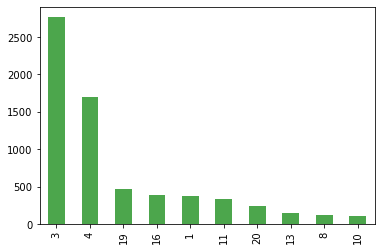

In [5]:
# Top 10 카테고리의 도수 분포를 막대그래프로 출력해 본다.
pd.Series(y_train).value_counts().sort_values(ascending=False)[:10].plot.bar(color= "green", alpha=0.7)
plt.show()

In [6]:
# X에서 임의의 문서 한 개 출력.
# Embedding 층에 입력하기 위해서 정수 (인덱스)로 인코딩 되어 있다!
print(X_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [7]:
# 첫 100 개의 문서 길이를 확인해 본다.
# 문서 길이가 일정하지 않음을 알 수 있다.
print([len(a) for a in X_train[0:100]])

[87, 56, 139, 224, 101, 116, 100, 100, 82, 106, 31, 59, 65, 316, 527, 76, 114, 17, 91, 77, 231, 108, 83, 29, 95, 110, 23, 373, 114, 354, 133, 222, 571, 155, 83, 208, 170, 269, 74, 19, 23, 78, 21, 377, 104, 299, 89, 56, 94, 139, 118, 36, 137, 107, 83, 66, 70, 112, 88, 51, 83, 123, 17, 185, 84, 52, 102, 73, 106, 486, 107, 82, 263, 172, 491, 190, 143, 62, 26, 88, 114, 38, 85, 112, 793, 104, 25, 21, 101, 28, 25, 81, 135, 73, 62, 18, 90, 266, 91, 64]


In [8]:
# 딕셔너리를 가져온다. 인덱스로 인코딩된 문서를 단어의 조합으로 변환할 수 있게 된다.
my_dict = get_word_index(path='reuters_word_index.json')

In [9]:
# 딕셔너리 출력.
#my_dict

In [10]:
# 'key' 와 'value'의 역할을 반대로 바꾸어 준다.
# 컴프리헨션 방법을 적용한다.
my_dict_inv = {v:k for k,v in my_dict.items()}

In [11]:
# 문서를 변환해서 출력해 본다.
i_news = 10                                        # 문서의 번호. 임의로 변경 가능하다.
news = list(pd.Series(X_train[i_news]).apply(lambda x: my_dict_inv[x]))
print(' '.join(news))

the federal gain only growth lt they meeting year reuter company did year an they of of reuter company of of 1987 had of of reuter had profits of pct dlrs


#### 3. 데이터 전처리:

In [12]:
# Padding: 문서의 길이는 일정하게 maxlen로 맞추어 진다.
# maxlen 보다 더 길면 자르고, 더 짧으면 0으로 채워 넣는다. 
X_train = pad_sequences(X_train, maxlen = 100, padding = 'pre')    # 'pre'  앞에 0을 넣는다. 'post' 뒤에 0을 넣는다.
X_test = pad_sequences(X_test, maxlen = 100, padding = 'pre')

In [13]:
# Padding된 결과를 본다.
X_train[:3,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   2,   2,   8,  43,  10, 447,   5,  25, 207, 270,   5,   2,
        111,  16, 369, 186,  90,  67,   7,  89,   5,  19, 102,   6,  19,
        124,  15,  90,  67,  84,  22, 482,  26,   7,  48,   4,  49,   8,
        864,  39, 209, 154,   6, 151,   6,  83,  11,  15,  22, 155,  11,
         15,   7,  48,   9,   2,   2, 504,   6, 258,   6, 272,  11,  15,
         22, 134,  44,  11,  15,  16,   8, 197,   2,  90,  67,  52,  29,
        209,  30,  32, 132,   6, 109,  15,  17,  12],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   2, 699,   2,   2,  56,   2,   2,
          9,  56,   2,   2,  81,   5,   2,  57, 366, 737, 132,  20,   2,
          7,   2,  49,   2,   2,   2,   2, 699,   2,   8,   7,  10, 24

In [14]:
# y 변수에 one-hot-encoding 변환 적용.
y = np.concatenate([y_train,y_test],axis=0)
y = to_categorical(y,46)
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

#### 4. 딥러닝 모델 정의:

In [15]:
n_hidden = 50                   # 개개 memory cell 안의 neuron 수.
n_emb = 100                     # Embedding 공간의 차원수. 

In [16]:
# LSTM network model.
my_model = Sequential(name="LSTM_network")
my_model.add(Embedding(n_words, n_emb, name="Embedding"))           # n_words = vocabulary 크기, n_emb = embedding 공간의 차원수.
my_model.add(LSTM(units=n_hidden, return_sequences=False, input_shape=(None, n_emb), activation='tanh',name="LSTM"))
my_model.add(Dense(n_cat, activation='softmax', name="Dense"))

In [17]:
# 모델의 summary (내부 구조) 출력.
# Embedding의 파라미터 수 = n_words * n_emb  = 1000 * 100 = 100000.  
# Embedding층의 역할은 차원 축소이다! 
# Embedding층에 개개 단어의 정수 인덱스를 입력하면 차원 축소된 밀집 벡터를 학습하게 된다! 
my_model.summary()

Model: "LSTM_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, None, 100)         100000    
_________________________________________________________________
LSTM (LSTM)                  (None, 50)                30200     
_________________________________________________________________
Dense (Dense)                (None, 46)                2346      
Total params: 132,546
Trainable params: 132,546
Non-trainable params: 0
_________________________________________________________________


#### 5. Hyperparameter 와 Optimizer 정의:

In [18]:
n_epochs = 30                      # Number of epochs.
batch_size = 32                    # Size of each batch.
learn_rate = 0.0005                 # learning rate.  

In [19]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 6. 학습 & History 시각화:

In [20]:
my_EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)          # 조기 종료 허락!
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split=0.2, verbose = 1, callbacks=[my_EarlyStop])

Epoch 1/30
197/197 [==============================] - 2s 11ms/step - loss: 2.6061 - accuracy: 0.3792 - val_loss: 2.1078 - val_accuracy: 0.4924
Epoch 2/30
197/197 [==============================] - 2s 11ms/step - loss: 2.0703 - accuracy: 0.4979 - val_loss: 1.9677 - val_accuracy: 0.5165
Epoch 3/30
197/197 [==============================] - 2s 9ms/step - loss: 2.0005 - accuracy: 0.5087 - val_loss: 1.9621 - val_accuracy: 0.5165
Epoch 4/30
197/197 [==============================] - 2s 10ms/step - loss: 1.9270 - accuracy: 0.5268 - val_loss: 1.8370 - val_accuracy: 0.5503
Epoch 5/30
197/197 [==============================] - 2s 11ms/step - loss: 1.8376 - accuracy: 0.5349 - val_loss: 1.6873 - val_accuracy: 0.5630
Epoch 6/30
197/197 [==============================] - 2s 11ms/step - loss: 1.7011 - accuracy: 0.5658 - val_loss: 1.6573 - val_accuracy: 0.5623
Epoch 7/30
197/197 [==============================] - 2s 11ms/step - loss: 1.6635 - accuracy: 0.5645 - val_loss: 1.6154 - val_accuracy: 0.5732


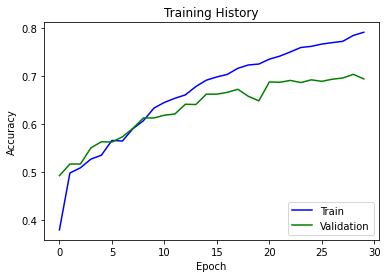

In [21]:
# 학습 history 출력. 
plt.plot(my_summary.history['accuracy'], c="b")
plt.plot(my_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 7. 테스팅: 

In [22]:
# 랜덤으로 테스트 문장을 추출해서 예측해 본다.
for i_test in [ random.randint(0,n_test_size-1) for _ in range(10)]:
    print("정답 :" , np.argmax(y_test[i_test]))
    print("예측 :" , np.argmax(my_model.predict(X_test[i_test].reshape(1,-1))))       # 2 차원 배열로 reshaping 해준다!!!
    y_pred_text = " ".join([my_dict_inv[x] for x  in X_train[i_test] if x != 0 ])     # padding 을 의미하는 0을 제외하고 문자열로 변환.  
    print(y_pred_text)
    print("-"*50)

정답 : 20
예측 : 11
that of foreign after with from of reuter from profits have five bid that of foreign but with of reuter of have five 13 a but 18 with from of reuter from of have five 13 a exchange farm with from of reuter from of have five friday of of of german slightly bid of foreign after with of reuter of have five bid of foreign but with of reuter of have five 13 a but 18 spending with were 27 reuter were of have five 13 a exchange farm with were of reuter were of have five pct dlrs
--------------------------------------------------
정답 : 2
예측 : 1
of of profit mln at market company's of of of profit 41 in note 3 annual said still was of iranian up 3 at of of up 1 mln of of traders and of in still 88 in around germany prime nil oil 1986 73 a for us council of of mln 1 of not note was of up shr he qtr of for index seeking said of of 3 20 of in institute and nations for rose c 600 said prices and dlr is said of of a co it ended said of 58 and of disclosed pct dlrs
--------------------

In [23]:
# 최종적으로 정확도 계산.
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.677
